<a href="https://colab.research.google.com/github/lexie21/miscellaneous/blob/main/data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install package
!pip install islp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 59.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 106.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=d2b99ce2507f52e118bb6ca4285eea8eca4f7f9266c8626055c730a0ec5b3554
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstall

In [ ]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots

import statsmodels.api as sm
from statsmodels.stats.outliers_influence \
import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                        summarize,
                        poly)

In [ ]:
# ISLP comes with a builtin load_data function
boston = load_data("Boston")
boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

In [ ]:
# Create the model matrix
X = pd.DataFrame({"intercept":np.ones(boston.shape[0]),
                  "lstat":boston['lstat']})
y = boston['medv']
model = sm.OLS(y,X) # model specification
results = model.fit() # model fit

In [ ]:
results.params

intercept    34.553841
lstat        -0.950049
dtype: float64

In [ ]:
design = MS(['lstat'])
X_ = design.fit_transform(boston)

In [ ]:
design

ModelSpec(terms=['lstat'])

In [ ]:
X_[:4]

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94


In [ ]:
# Pick out a few datapoints only
new_df = pd.DataFrame({'lstat':[5,10,15]})
newX = design.transform(new_df)
newX

,intercept,lstat
0,1.0,5
1,1.0,10
2,1.0,15


In [ ]:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean
print(new_predictions.conf_int(alpha=0.5))
print(new_predictions.conf_int(obs=True,alpha=0.5))

# Sanity check with result: prediction interval is indeed wider than confidence interval

[[29.53006154 30.07712669]
 [24.85435487 25.25233981]
 [20.10675447 20.49944667]]
[[25.59919254 34.00799568]
 [20.85313657 29.25355811]
 [16.10301435 24.5031868 ]]


In [ ]:
# Func to add regression lines onto plots
def abline(ax,b,m,*args,**kwargs):
  "Add a line with slope m and intercept b to ax"
  xlim = ax.get_xlim()
  ylim = [m*xlim[0]+b,m*xlim[1]+b]
  ax.plot(xlim,ylim,*args,**kwargs)

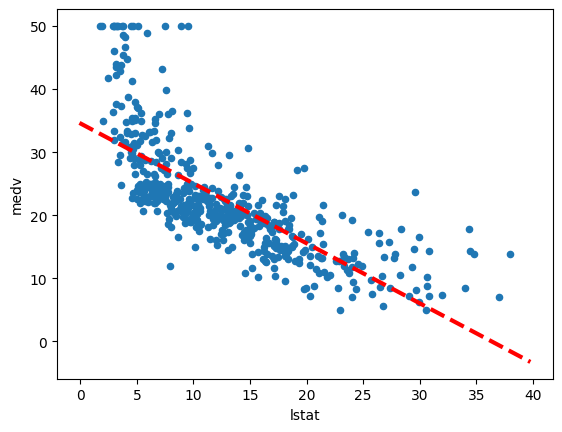

In [ ]:
ax = boston.plot.scatter('lstat','medv')
abline(ax,
       results.params[0],
       results.params[1],
       'r--',
       linewidth=3)

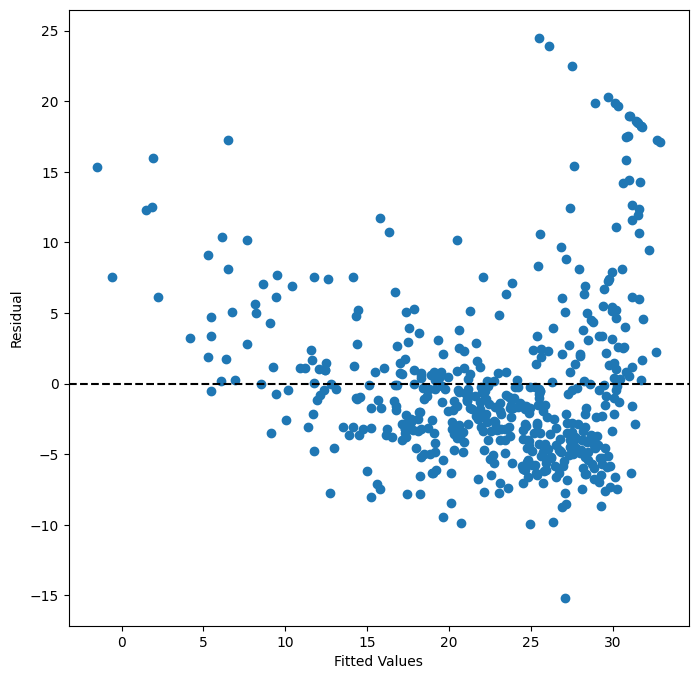

In [ ]:
# Diagnostic plots
ax = subplots(figsize=(8,8))[1]
ax.scatter(results.fittedvalues,results.resid)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residual')
ax.axhline(0,c='k',ls='--')

# Plot clearly shows some missing correlation

In [ ]:
# Multiple regression model
X = MS(['lstat','age']).fit_transform(boston)
model1 = sm.OLS(y,X)
results1 = model1.fit()
summarize(results1)

,coef,std err,t,P>|t|
intercept,33.2228,0.731,45.458,0.000
lstat,-1.0321,0.048,-21.416,0.000
age,0.0345,0.012,2.826,0.005


In [ ]:
terms = boston.columns.drop('medv')
X_mlr = MS(terms).fit_transform(boston)
model2 = sm.OLS(y,X_mlr)
results2 = model2.fit()
summarize(results2)

,coef,std err,t,P>|t|
intercept,41.6173,4.936,8.431,0.000
crim,-0.1214,0.033,-3.678,0.000
zn,0.0470,0.014,3.384,0.001
indus,0.0135,0.062,0.217,0.829
chas,2.8400,0.870,3.264,0.001
nox,-18.7580,3.851,-4.870,0.000
rm,3.6581,0.420,8.705,0.000
age,0.0036,0.013,0.271,0.787
dis,-1.4908,0.202,-7.394,0.000
rad,0.2894,0.067,4.325,0.000


In [ ]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Wed, 04 Oct 2023   Prob (F-statistic):           5.08e-88
Time:                        04:11:11   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# VIF
vals = [VIF(X_mlr, i) for i in range(1,X_mlr.shape[1])] #over all cols
vif = pd.DataFrame({'vif':vals},
                   index=X_mlr.columns[1:])
vif
# vif is used to test multi/collinearity later

,vif
crim,1.767486
zn,2.298459
indus,3.987181
chas,1.071168
nox,4.369093
rm,1.912532
age,3.088232
dis,3.954037
rad,7.445301
tax,9.002158


In [ ]:
# Add interaction terms
X = MS(['lstat',
        'age',
        ('lstat','age')]).fit_transform(boston)
model3 = sm.OLS(y,X)
summarize(model3.fit())

,coef,std err,t,P>|t|
intercept,36.0885,1.470,24.553,0.000
lstat,-1.3921,0.167,-8.313,0.000
age,-0.0007,0.020,-0.036,0.971
lstat:age,0.0042,0.002,2.244,0.025


In [ ]:
# Add polynomial transform
X = MS([poly('lstat',degree=2),'age']).fit_transform(boston)
model4 = sm.OLS(y,X)
results4 = model4.fit()
summarize(results4)

,coef,std err,t,P>|t|
intercept,17.7151,0.781,22.681,0.0
"poly(lstat, degree=2)[0]",-179.2279,6.733,-26.620,0.0
"poly(lstat, degree=2)[1]",72.9908,5.482,13.315,0.0
age,0.0703,0.011,6.471,0.0


In [ ]:
# F-test to see whether the new predictor's relationship is statistically significant
anova_lm(results1,results4)
# p-value ~ 0 => shows that the model with quadratic lstat term explains the data more accurately

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,503.0,19168.128609,0.0,NaN,NaN,NaN
1,502.0,14165.613251,1.0,5002.515357,177.278785,7.468491e-35


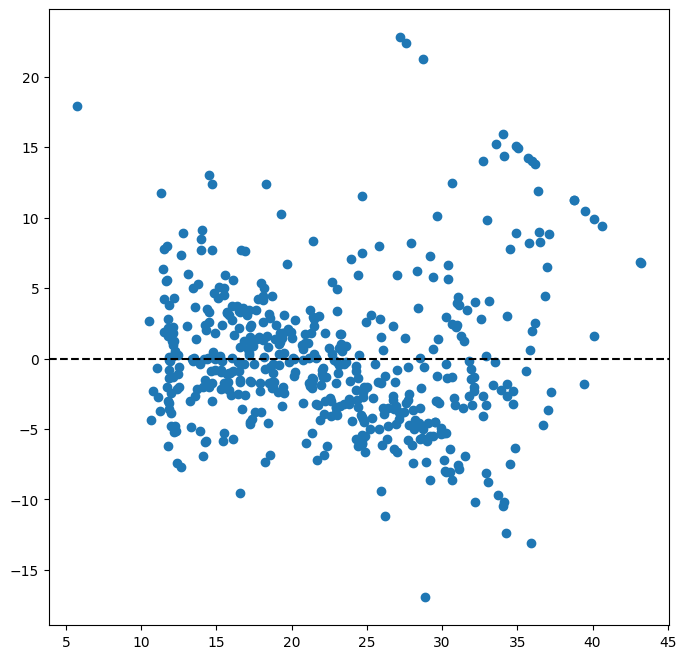

In [ ]:
# Plot again with quadratic term
ax = subplots(figsize=(8,8))[1]

# Residual vs fitted value plot to check any patterns undetected
ax.scatter(results4.fittedvalues,results4.resid)

# Name axes
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residual')

# Add a horizontal line at 0
ax.axhline(0,c='k',ls='--')

In [ ]:
# Another dataset, with qualitative predictors
carseats = load_data('Carseats')
carseats.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [ ]:
allvars = list(carseats.columns.drop('Sales'))
y = carseats['Sales']
final = allvars + [('Income','Advertising'),
                   ('Price','Age')]
X = MS(final).fit_transform(carseats)
model = sm.OLS(y,X)
summarize(model.fit())


,coef,std err,t,P>|t|
intercept,6.5756,1.009,6.519,0.000
CompPrice,0.0929,0.004,22.567,0.000
Income,0.0109,0.003,4.183,0.000
Advertising,0.0702,0.023,3.107,0.002
Population,0.0002,0.000,0.433,0.665
Price,-0.1008,0.007,-13.549,0.000
ShelveLoc[Good],4.8487,0.153,31.724,0.000
ShelveLoc[Medium],1.9533,0.126,15.531,0.000
Age,-0.0579,0.016,-3.633,0.000
Education,-0.0209,0.020,-1.063,0.288


In [ ]:
# Applied exercise in the book

#1. Load data
auto = load_data('Auto')
auto.columns

#2. Create the model matrix and fit
X = MS(['horsepower']).fit_transform(auto)
y = auto['mpg']
model = sm.OLS(y,X)
results = model.fit()
summarize(model.fit())

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name'],
      dtype='object')

In [ ]:
#3. Predictions on a few datapoints
design = MS(['horsepower'])

new_df = auto.loc[auto['horsepower']==98]
newX = design.fit_transform(new_df)
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

,intercept,horsepower
177,1.0,98
226,1.0,98


In [ ]:
# This dataset is generated
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = 2*x+rng.normal(size=100)

In [ ]:
# Regress y on x
design = MS(['x'],intercept=False)
X = pd.DataFrame(x,columns=['x'])
X = design.fit_transform(X)
model = sm.OLS(y,X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
x,1.9762,0.117,16.898,0.0


In [ ]:
# Regress x on y
design = MS(['y'],intercept=False)
Y = pd.DataFrame(y,columns=['y'])
Y = design.fit_transform(Y)
model = sm.OLS(x,Y)
results = model.fit()
summarize(results)

# Results of 2 regressions show that without an intercept, the t-statistic of regressing y on x is the same as that of regressing x on y (algebraic property)

,coef,std err,t,P>|t|
y,0.3757,0.022,16.898,0.0
